In [2]:
pip install torch torchvision matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os
import torch.nn.functional as F
import numpy as np

In [4]:
print("CUDA Version:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())

from zipfile import ZipFile

with ZipFile("/content/legoface.zip", 'r') as zObject:

    zObject.extractall(
        path="/content")

CUDA Version: 12.1
Is CUDA available: True
CUDA Device Count: 1


In [5]:
height = 128
width = 128

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((height, width)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Create a custom dataset with the defined transformations
dataset = CustomDataset(root_dir='/content/legoface', transform=transform)

In [6]:
num_epochs = 111111

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # Added padding here
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # Added padding here
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # Added padding here
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # Added padding here
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),  # Added padding here
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


In [9]:
criterion = nn.BCELoss()
netD = Discriminator().cuda()  # Assuming your discriminator is named Discriminator and it's defined somewhere in your code
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
netG = Generator().cuda()  # Assuming your generator is named Generator and it's defined somewhere in your code
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

In [10]:
print("Output size:", output_real.size())
print("Label size:", label_real.size())

NameError: name 'output_real' is not defined

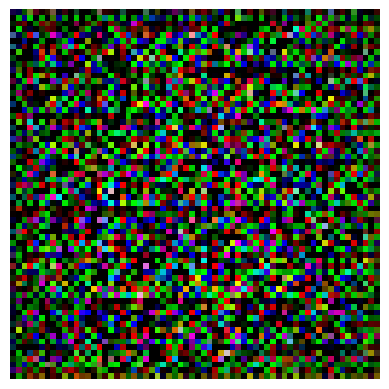

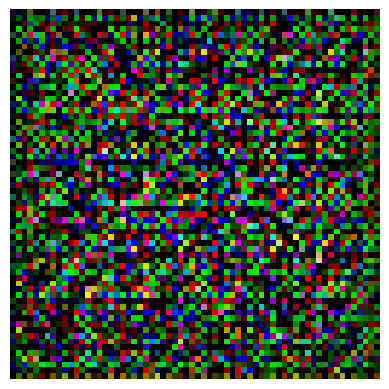

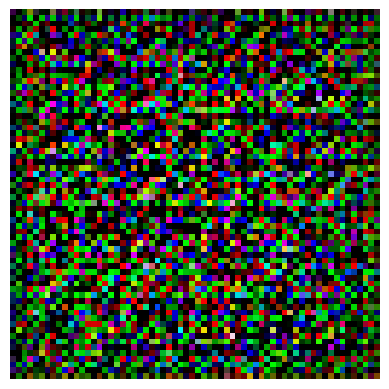

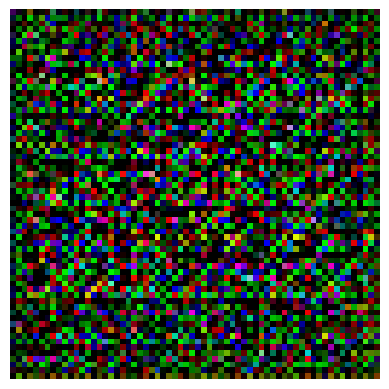

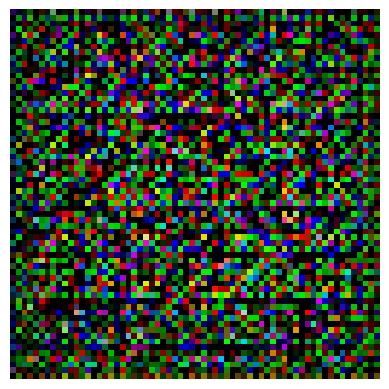

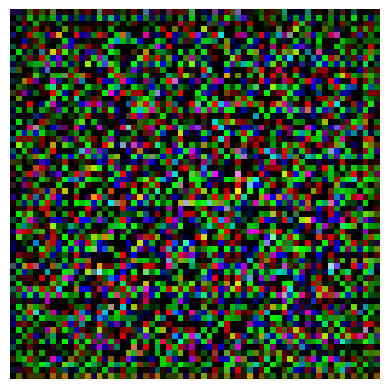

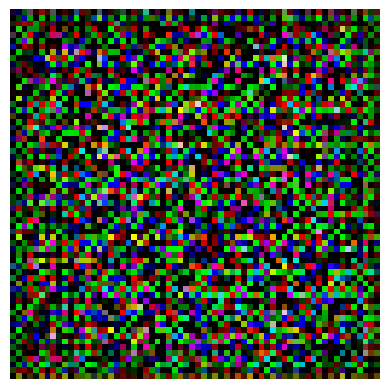

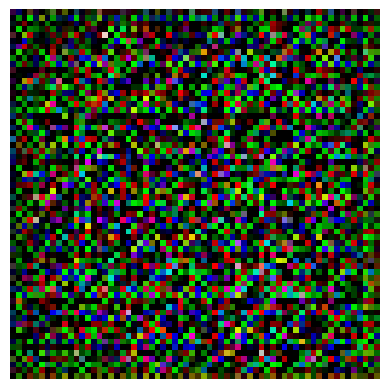

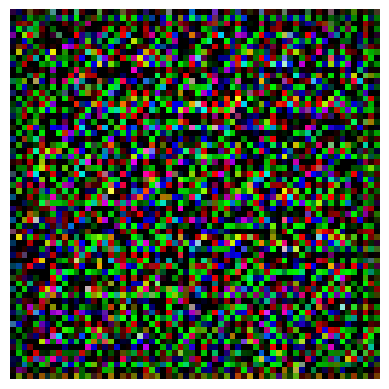

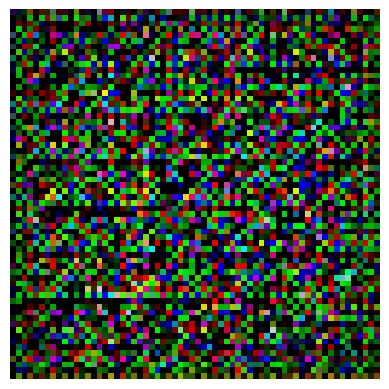

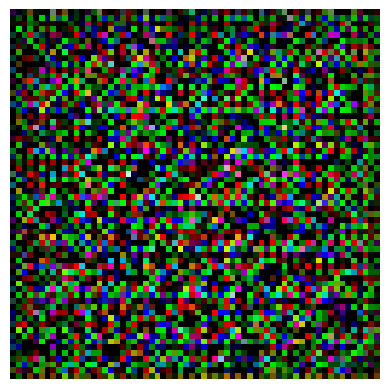

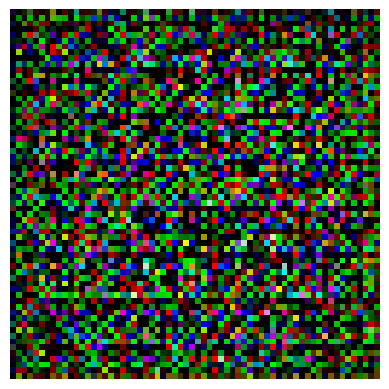

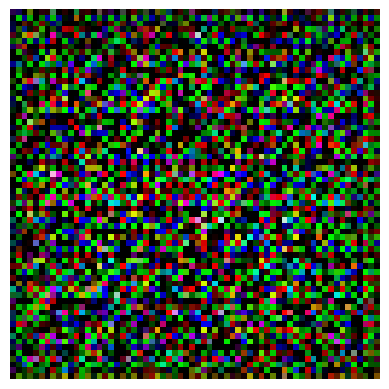

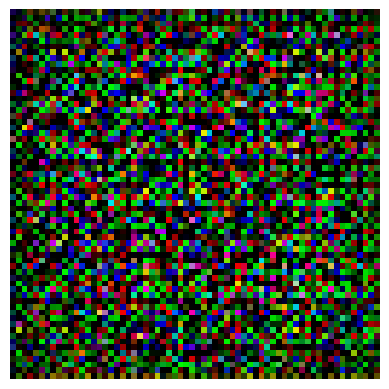

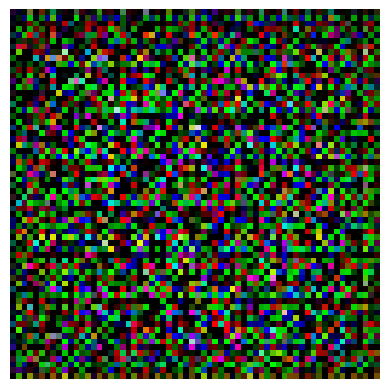

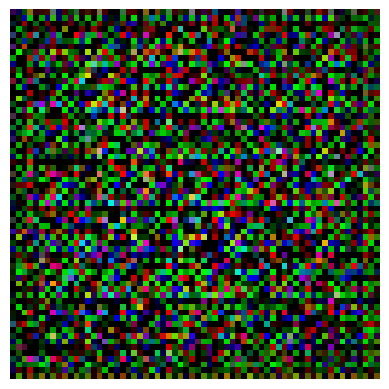

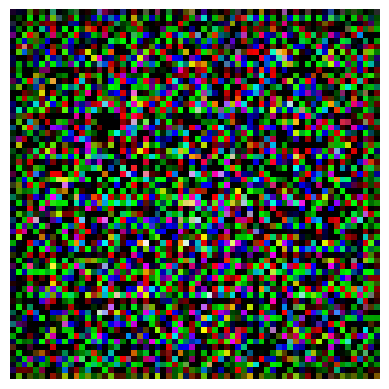

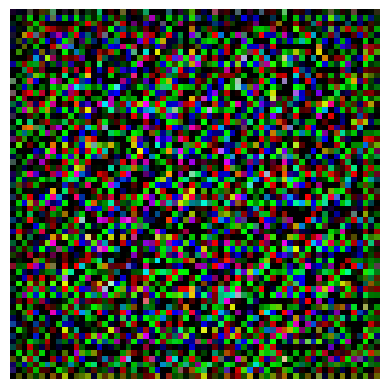

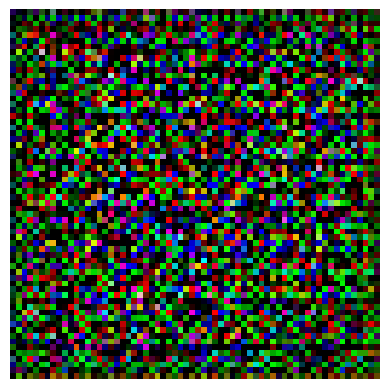

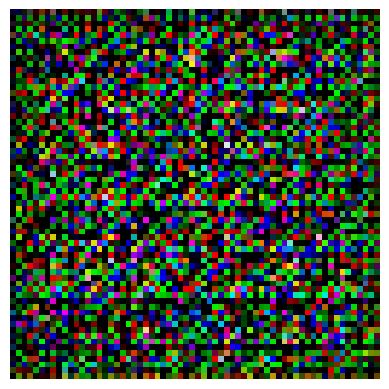

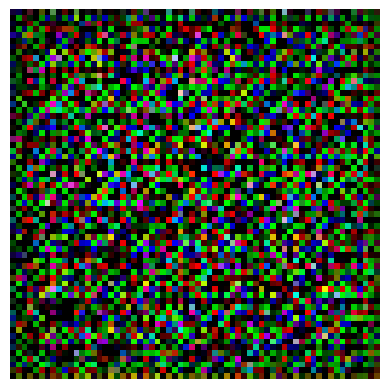

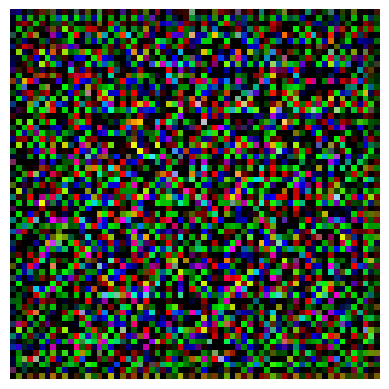

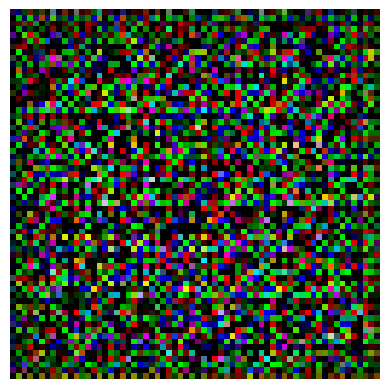

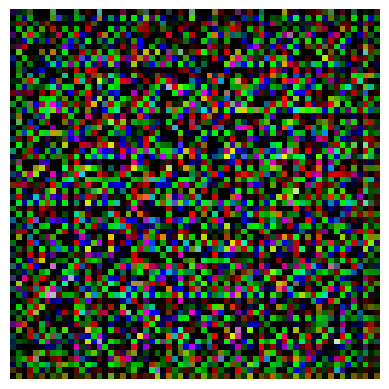

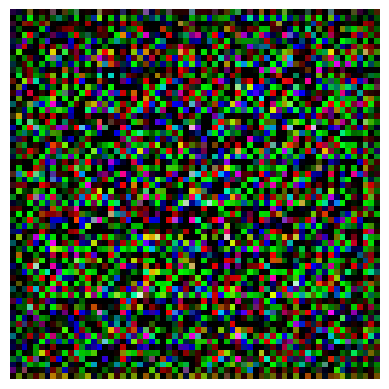

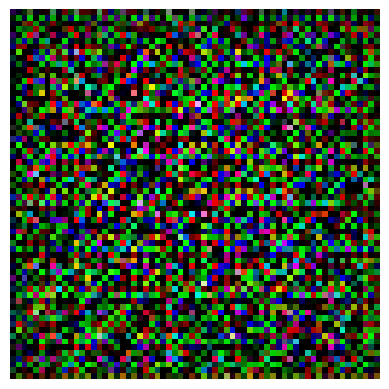

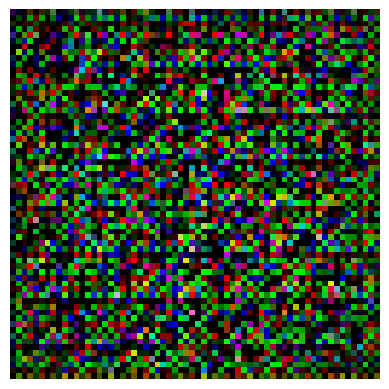

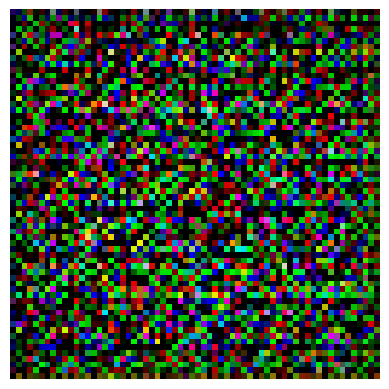

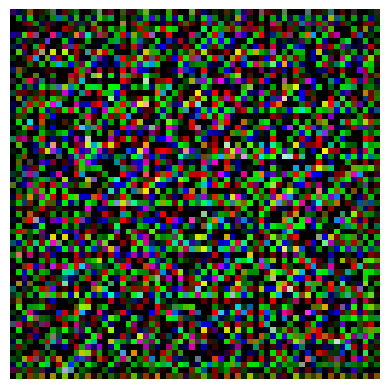

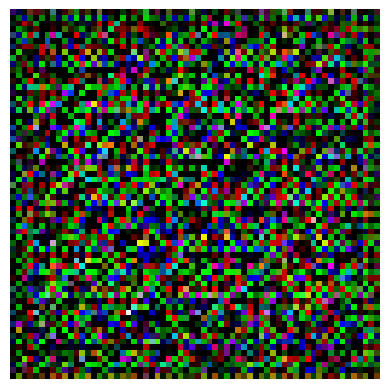

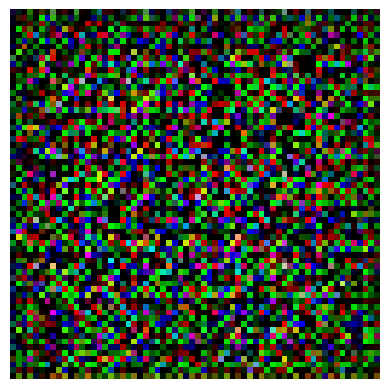

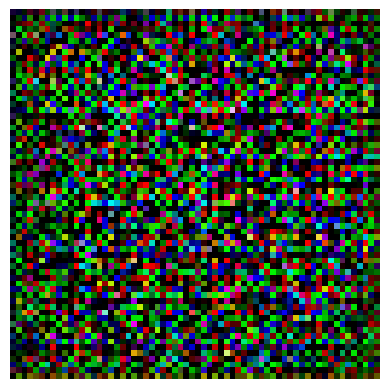

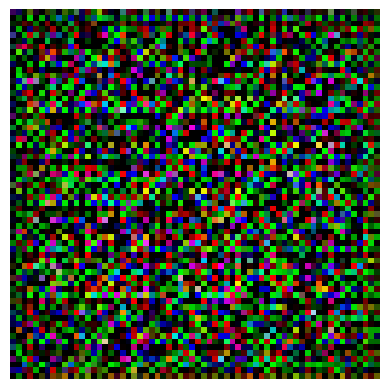

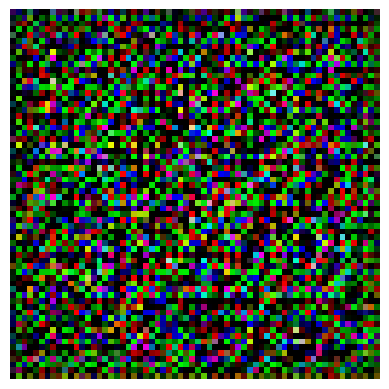

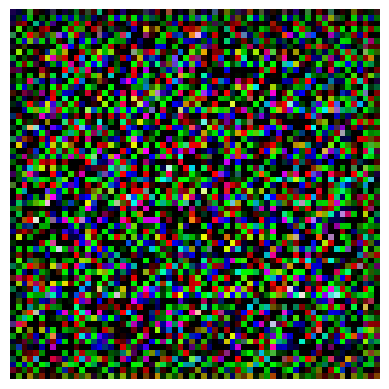

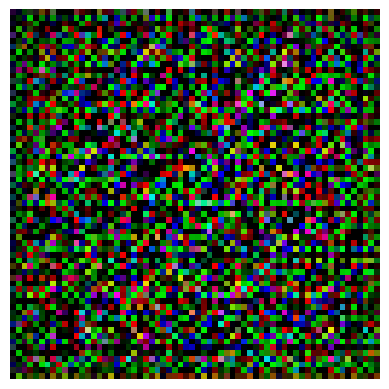

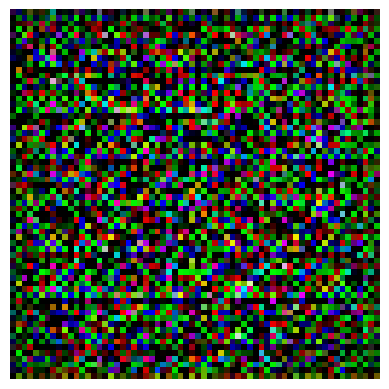

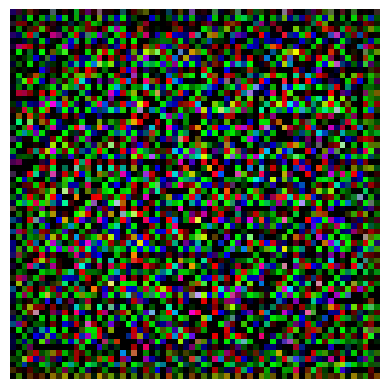

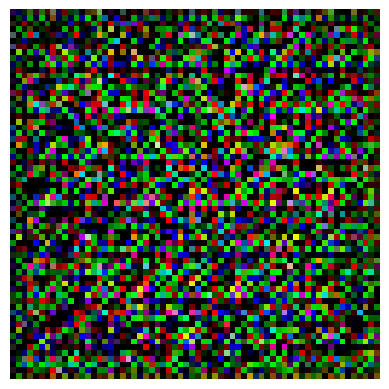

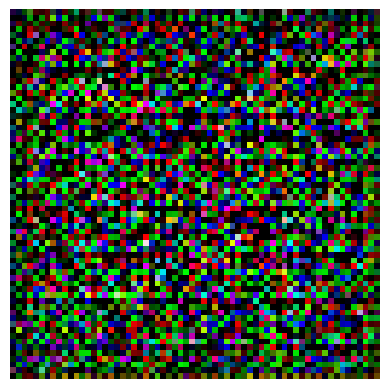

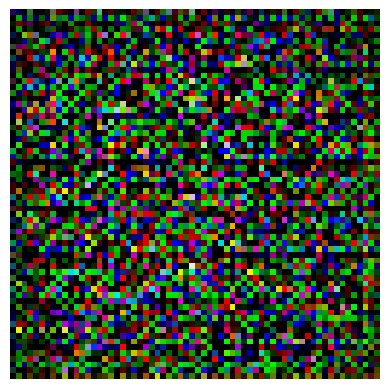

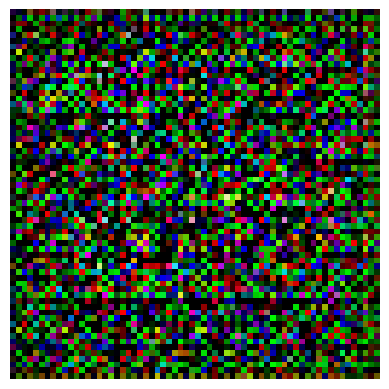

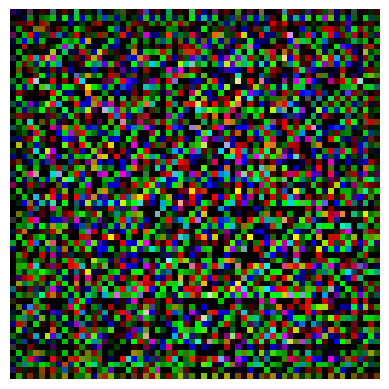

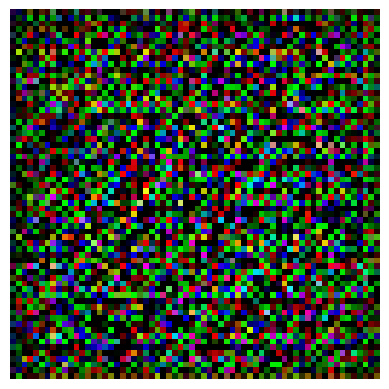

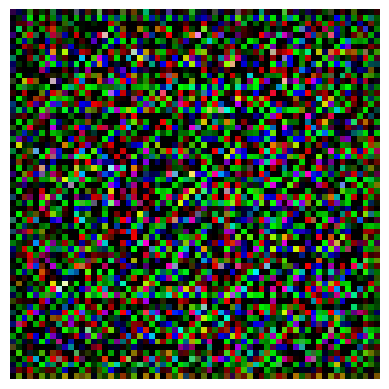

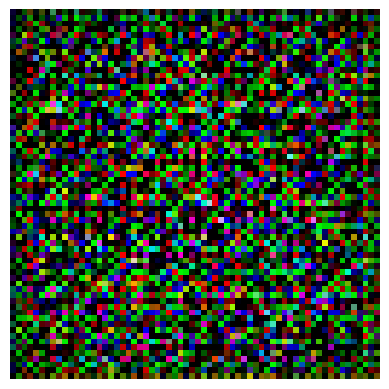

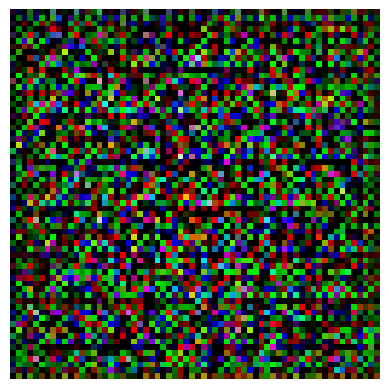

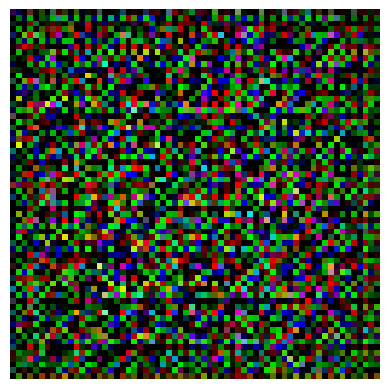

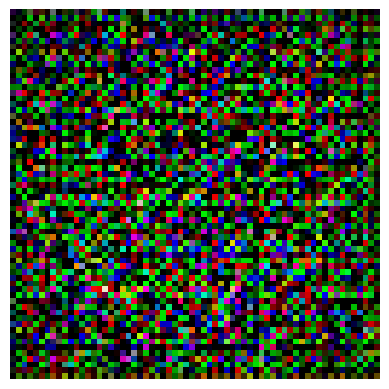

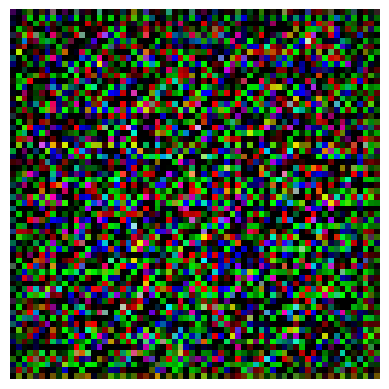

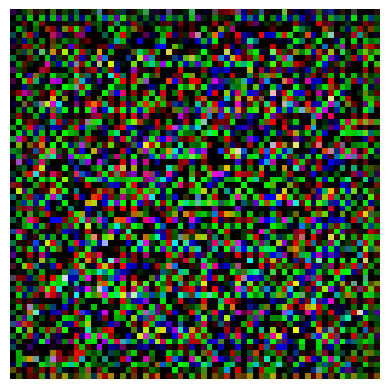

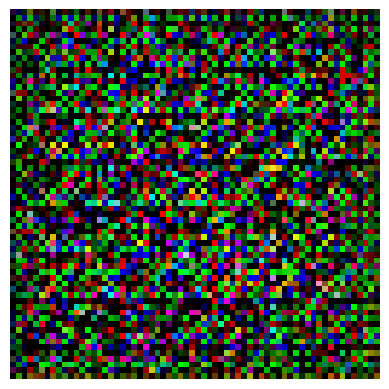

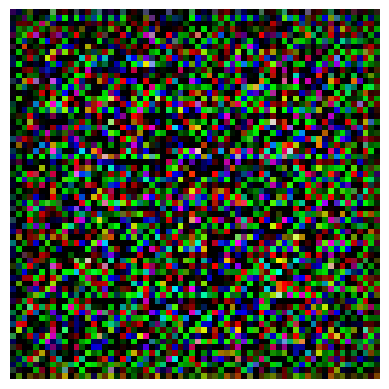

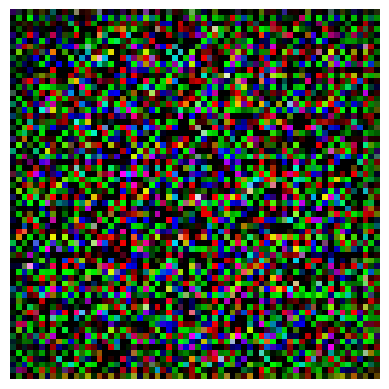

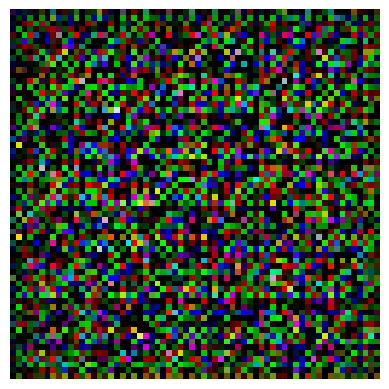

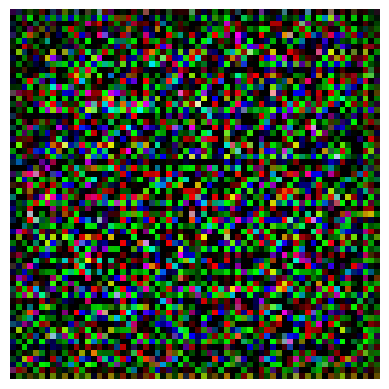

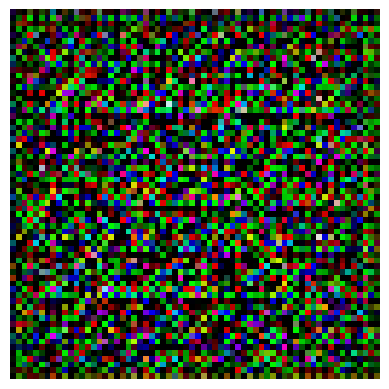

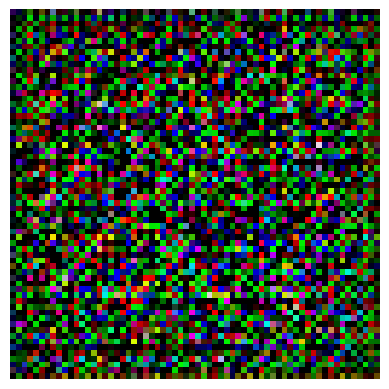

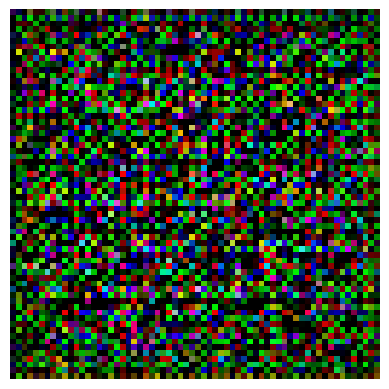

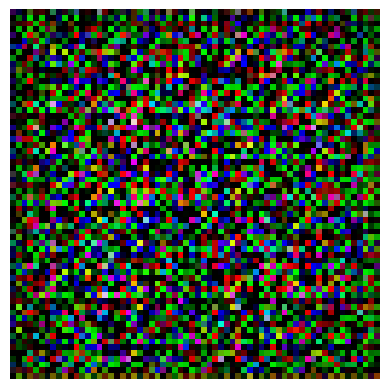

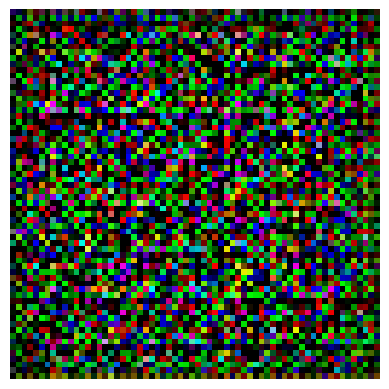

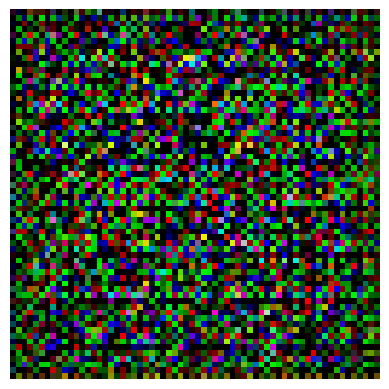

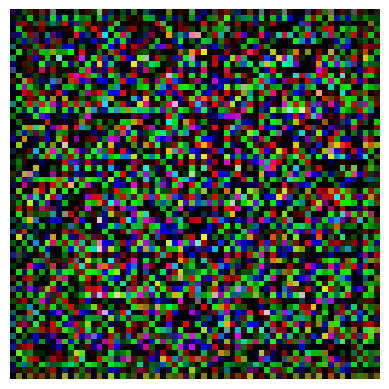

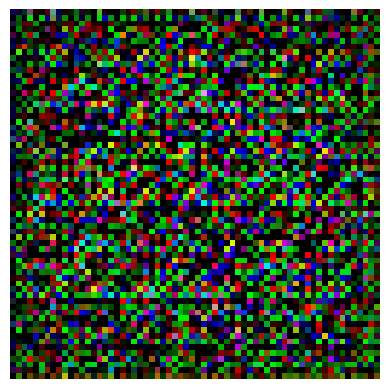

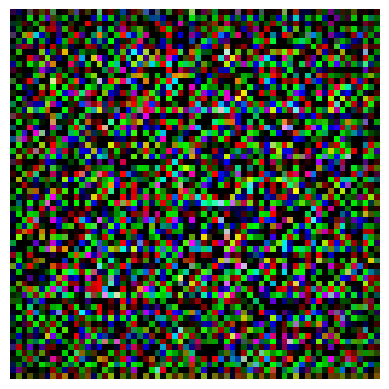

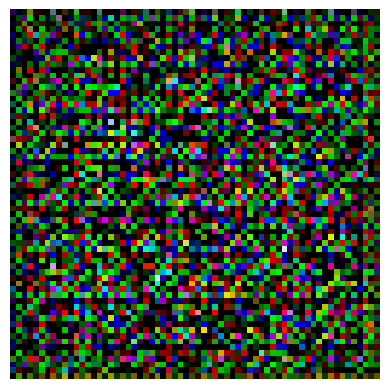

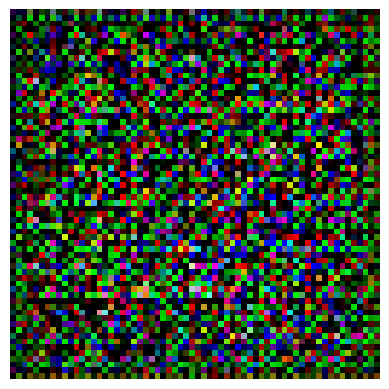

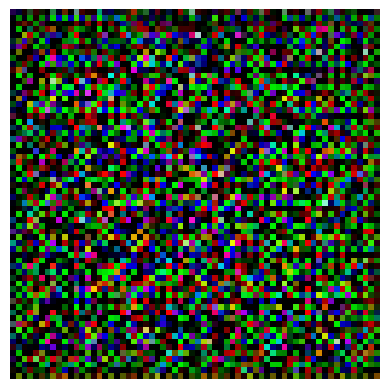

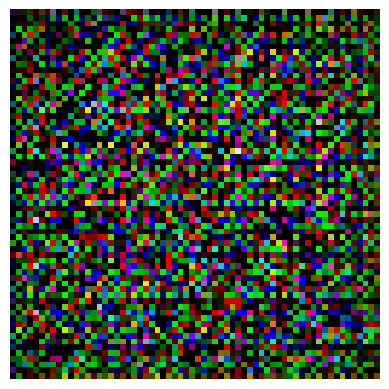

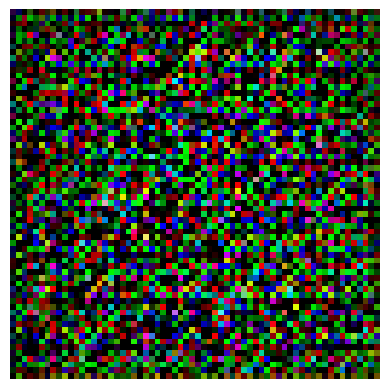

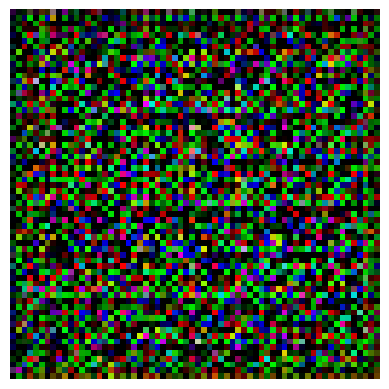

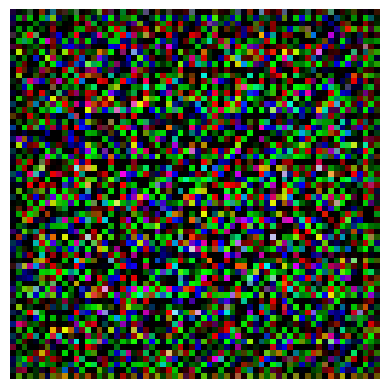

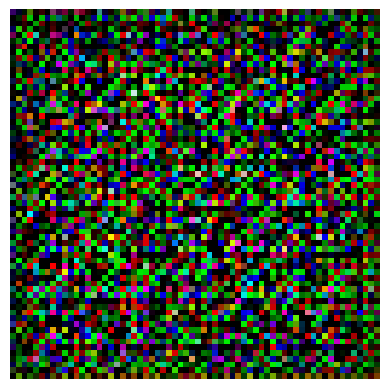

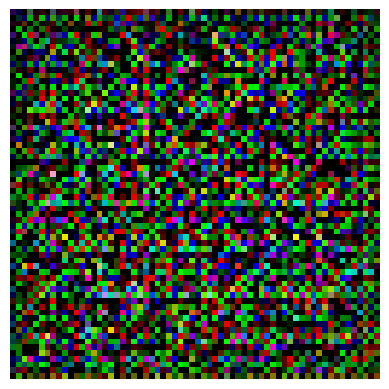

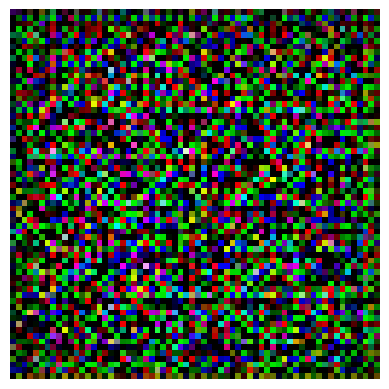

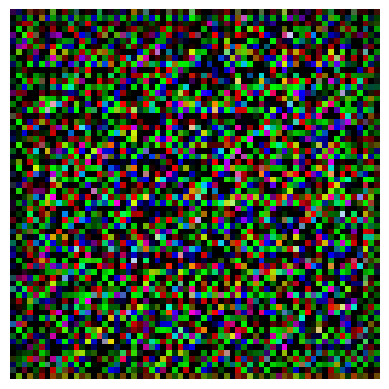

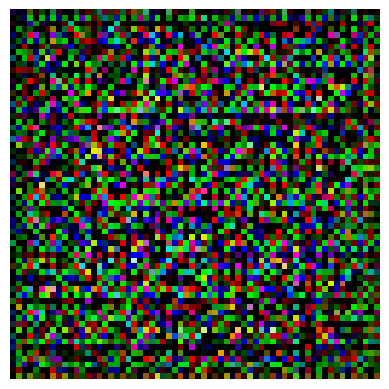

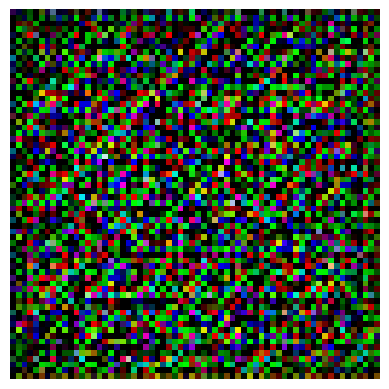

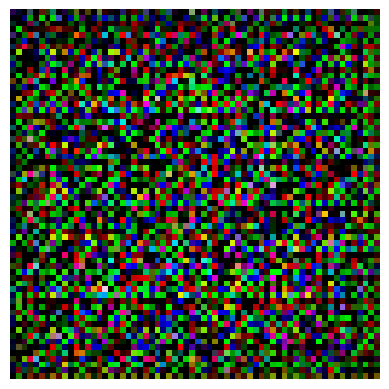

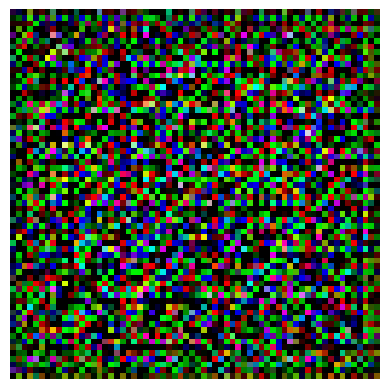

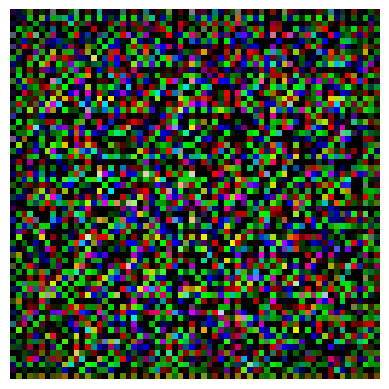

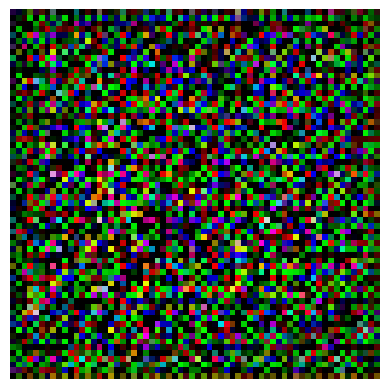

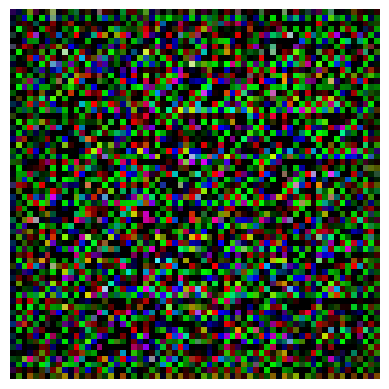

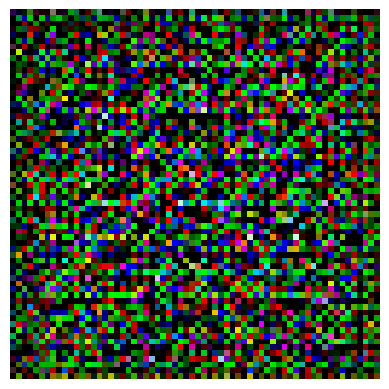

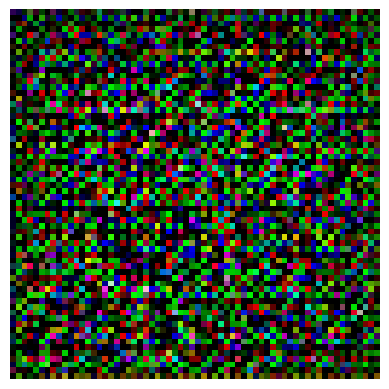

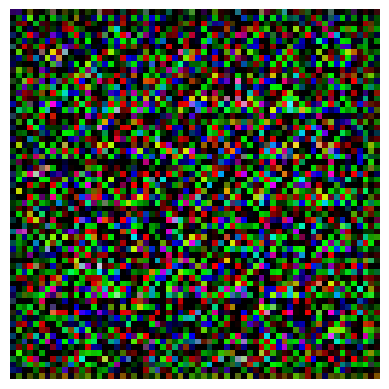

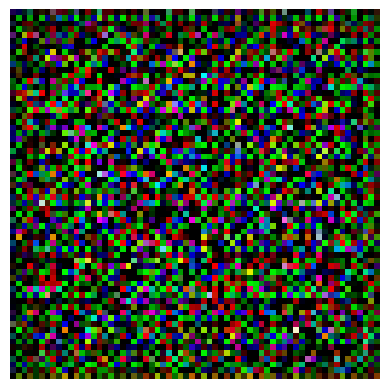

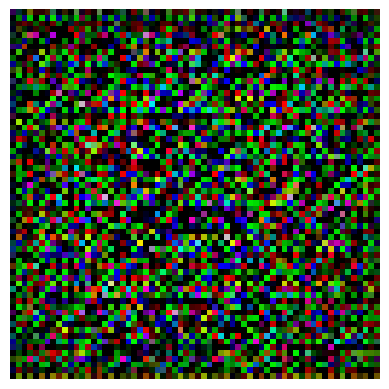

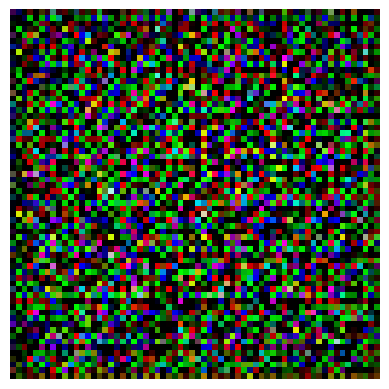

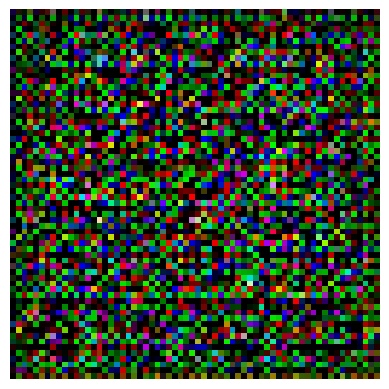

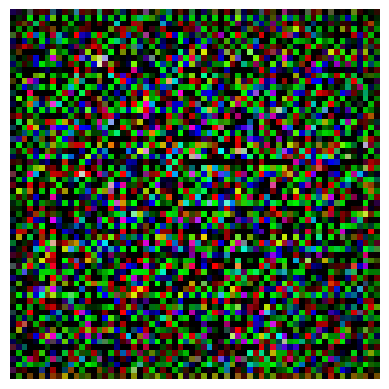

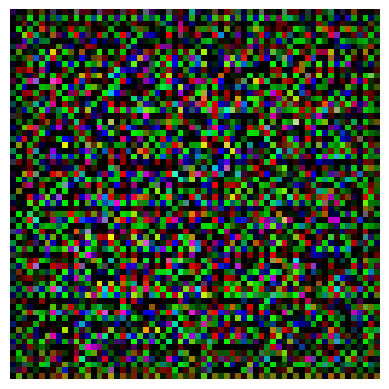

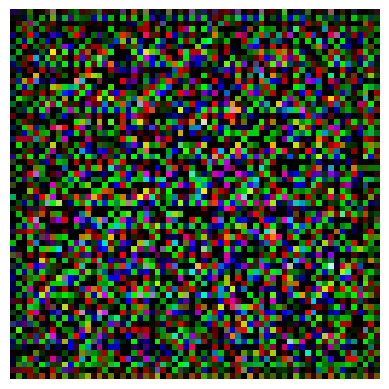

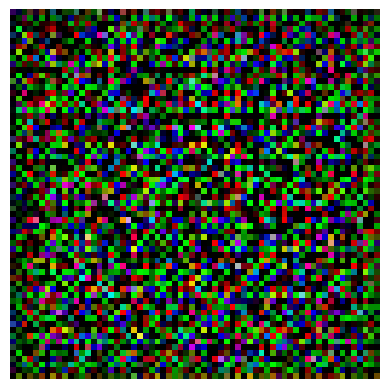

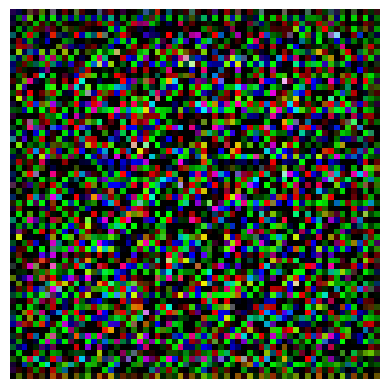

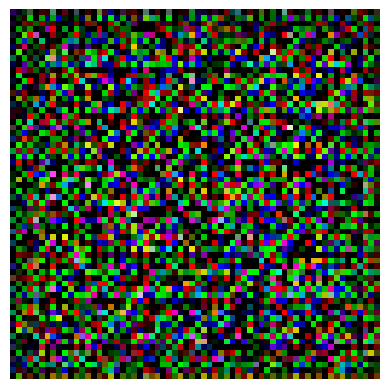

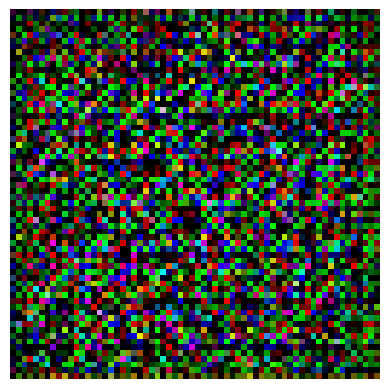

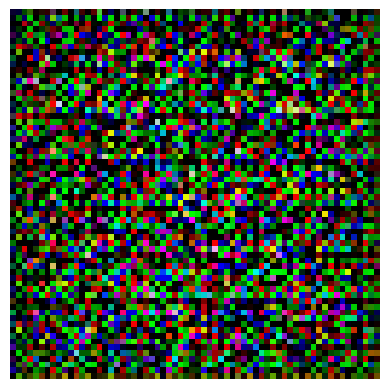

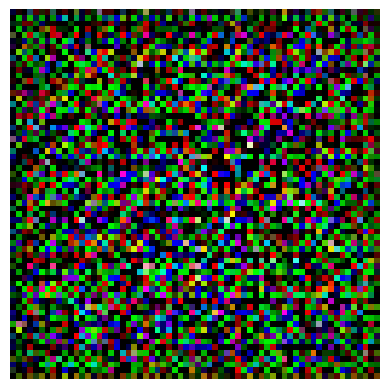

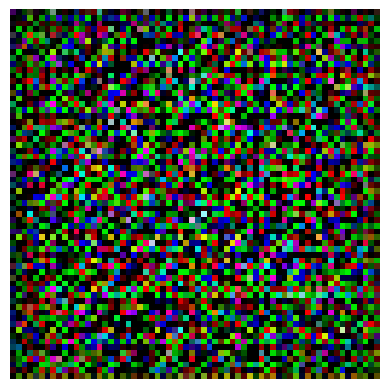

In [11]:
# Instantiate models
netG = Generator().cuda()
netD = Discriminator().cuda()

criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop for the Discriminator and Generator
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real = data.cuda()
        b_size = real.size(0)
        label_real = torch.full((b_size,), 1, dtype=torch.float, device='cuda')
        output_real = netD(real)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()

        # Generate fake images and calculate loss
        noise = torch.randn(b_size, 100, 1, 1, device='cuda')
        fake = netG(noise)
        label_fake = torch.full((b_size,), 0, dtype=torch.float, device='cuda')
        output_fake = netD(fake.detach())
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label_real.fill_(1)  # Fake labels are real for generator cost
        output_fake = netD(fake)
        errG = criterion(output_fake, label_real)
        errG.backward()
        optimizerG.step()

        # Print losses for each batch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(dataloader)}] Loss D: {errD_real + errD_fake}, loss G: {errG}")

    if (epoch + 1) % 1111 == 0:
        # Generate some noise
        noise = torch.randn(64, 100, 1, 1, device='cuda')
        # Generate fake images
        fake_images = netG(noise).detach().cpu()
        # Save the images
        save_image(fake_images, f'/content/generated_images_epoch_{epoch + 1}.png', normalize=True)

        # Display the first generated image
        plt.imshow(np.transpose(fake_images[0], (1, 2, 0)))
        plt.axis('off')
        plt.show()


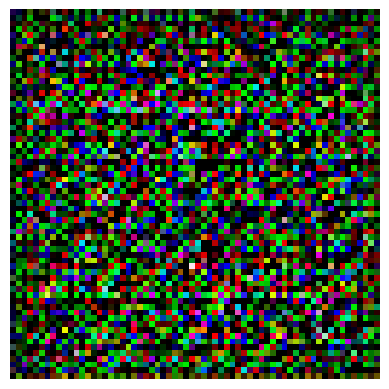

In [12]:
def plot_generated_images(generator, noise):
    # Generate fake images
    fake_images = generator(noise).detach().cpu()

    # Save generated images to file
    save_image(fake_images, '/content/generated_images.png', normalize=True)

    # Clip values to the valid range
    clipped_images = np.clip(fake_images, 0, 1)

    # Plot the first generated image
    plt.imshow(np.transpose(clipped_images[0], (1, 2, 0)))
    plt.axis('off')
    plt.show()

noise = torch.randn(64, 100, 1, 1, device='cuda')
plot_generated_images(netG, noise)